# Detect distracted drivers
*Cyril Pecoraro - June 1st 2018*

The goal is to predict what the driver is doing based on pictures

This project is from a [Kaggle competition : State Farm Distracted Driver Detection
](https://www.kaggle.com/c/state-farm-distracted-driver-detection)

There are 10 classes to predict:
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

### Explanation of my work

I used a pre-trained VGG-16 Convolutional Neural Network as a base layer. I then removed the last layer (=top layer) and added a Dense layer with a softmax to output the classification. The optimization algorithm is Adam with a small learning rate: **/tofill/**  . 


The used the weights trained VGG-16 on the image-net dataset for the initializatzion. All the layers beside the last **/tofill/**  were frozen. I then performed data augmentation because the training set is not big. I fine tuned the model using the training set and a validation set (33% split)

I used the Keras library as much as possible in this project as it allows to prototype quickly and surely. I used the dataflow and datagen functions to load the file and preprocess them while feeding them by batches directly to the model.


**/tofill/** epochs were used. The learning_rate, number of epochs and numbers of layers to freeze values were determined by several experiments, not shown here. 


The framework was run on a Google Cloud Virtual Machine with a Tesla K80 GPU.

#### To predict:
* Run the last cell of this notebook
* Or use the script `predict.py [Model/model_name]` with the desired model to obtain prediction and generate a .csv file for Kaggle.

### Content:

1. Model building
2. Preprocessing and data augmentation
3. Train
4. Predict

#### Config to adjust:

In [1]:
# Params 
batch_size = 256
n_epoch = 15
learning_rate = 0.0001
n_layers_freeze = 14 # last 14 layers will be trained

In [2]:
import pandas as pd
import cv2
import os 
import glob
import gc
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import warnings
warnings.filterwarnings("ignore", module="matplotlib")
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from keras.applications import vgg16
from keras.preprocessing import image
from keras import optimizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense 
from tensorflow.python.client import device_lib
import tensorflow as tf

from livelossplot import PlotLossesKeras


Using TensorFlow backend.



First we can observe the distribution of samples per class. This is important as it is a classification problem. In order to avoid the [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox), we don't want to have classes too imbalanced. Here the classes are pretty well balanced. All good !


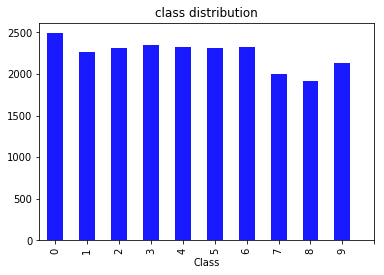

In [3]:
img_list = pd.read_csv('Data/driver_imgs_list.csv')

img_list['class_type'] = img_list['classname'].str.extract('(\d)',expand=False).astype(np.int)
plt.figure()
img_list.groupby(['class_type'])['subject'].count().plot(kind='bar',alpha=0.9, layout=(1,1), color='b')
plt.title('class distribution')
plt.xticks(range(0,11))
plt.xlabel('Class')
plt.show()


## 1. Model building

I use the VGG16 implementation and I remove the last layer to add a layer that suits my needs. In this case it is a 10 Fully connected layer so that I can use the CNN as a 10-class classifier.

In [4]:
def create_VGG16_model(n_classes=10, n_layers_freeze=1, input_shape=(224, 224, 3), learning_rate=0.0001):
    """Load the images located in the main folder dataset_dir Each class is in a separate subfolder
    Args:
    - n_classes: number of classes to predict for the classifier
    - n_layers_freeze: number of last layers to freeze so that they are not trained again
    Return:
    - model: Keras model
    """
    #Load the VGG model
    vgg16_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers except the last n_layers_freeze layers
    #for layer in vgg16_base.layers[:-n_layers_freeze]:
    #    layer.trainable = False

    model = Sequential(name='VGG16-classifier')
    model.add(vgg16_base)
    model.add(Flatten(input_shape=model.output_shape[1:]))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss='binary_crossentropy',
          optimizer=optimizers.Adam(lr=learning_rate),
          metrics=['accuracy'])

    model.summary()
    return model

In [5]:
# Create and compile model
model = create_VGG16_model(n_layers_freeze=n_layers_freeze, learning_rate=learning_rate)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                250890    
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________


In [6]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8665549948246957249
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11272526234
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8206017306551087545
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## 2. Preprocessing and data augmentation 

Thanks to Keras, it is possible to load batches of data, preprocess them, augment them, split them in train/validation set, and feed them to the model directly.

The data augmentation allows to increase the size of the training set. 

In [ ]:
# Working directories#  
dataset_dir = 'Data'
dataset_dir_train = os.path.join(dataset_dir, 'train')

# Image sizes - Requirements of the CNN model
img_reshape_size = (224,224)

# Image Data Generator for preprocessing and data augmentation
datagen = image.ImageDataGenerator(
        preprocessing_function=vgg16.preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.33)

## 3. Train

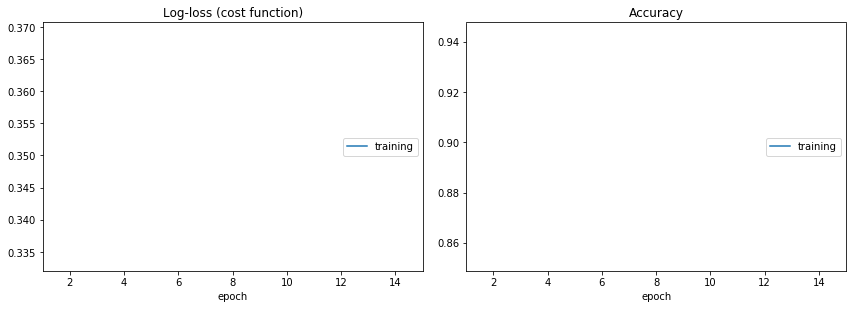

Epoch 2/15


In [ ]:
# fits the model on batches with real-time data augmentation:
model_history = model.fit_generator(datagen.flow_from_directory(dataset_dir_train,
                                                                target_size=img_reshape_size,
                                                                batch_size=150,
                                                                shuffle=True,
                                                                seed=42),
                                    shuffle=True,
                                    epochs=n_epoch,
                                    verbose=2,
                                    callbacks=[PlotLossesKeras()],
                                    use_multiprocessing=True)

Now that the model is trained, we can save it and exit this notebook.

Use the script `predict.py [Model/model_name]` to obtain prediction and generate a .csv file for Kaggle

In [ ]:
# Save model and Exit
if not os.path.isdir('Model'):
    os.mkdir('Model')
filename = 'VGG16_lr'+str(learning_rate)+'_freeze'+str(n_layers_freeze)+'_epochs'+str(n_epoch)+'.h5'
sub_file = os.path.join('Model', filename)
model.save(sub_file)
print('File', filename, 'saved')


## 4. Predict and submit

In [ ]:
#model_to_use = sub_file
%run -i 'predict.py' sub_file
!kaggle competitions submit -c state-farm-distracted-driver-detection -f "$(ls -t Output/submission-* | head -1)" -m "."